<a href="https://colab.research.google.com/github/konstantin1998/first-repository/blob/master/litpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchsummary

from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import PIL
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
class DataGenerator():
  def __init__(self, train_dir, test_dir, results_file):
    self.train_dir = train_dir
    self.test_dir = test_dir
    results_df = pd.read_csv(results_file)
    self.results = pd.Series(results_df['score'].values, index=results_df['name'].values)
  
  def get_quality(self, img_path):
    dir, name = os.path.split(img_path)
    quality = self.results[name]
    return quality

  def load_sample(self, path):
    try:
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      img = img.reshape((1, *img.shape)).astype('float32')
      tensor = torch.from_numpy(img)
      return tensor
    except AttributeError:
      print('exception in load_sample:', path)
  
  def shuffle(self, arr):
    part1, part2 = train_test_split(arr, train_size=0.5, random_state=42)
    part1.extend(part2)
    return part1

  def assign_qualities(self, dataset):
    items = []
    for sample in dataset.samples:
      path, label = sample
      quality = self.get_quality(path) 
      sample = (path, float(quality))
      items.append(sample)
    items = self.shuffle(items)
    dataset.samples = items

  def prepare_data(self):
    trainset = torchvision.datasets.ImageFolder(
      root=self.train_dir,
      loader=self.load_sample
    )
    self.assign_qualities(trainset)
    trainloader = torch.utils.data.DataLoader(
      trainset,
      batch_size=80,
      shuffle=False,
      num_workers=4
    )
    print(len(trainset.samples))
    testset = torchvision.datasets.ImageFolder(
      root=self.test_dir,
      loader=self.load_sample
    )
    print(len(testset.samples))
    self.assign_qualities(testset)
    testloader = torch.utils.data.DataLoader(
      testset,
      batch_size=30,
      shuffle=False, 
      num_workers=2
    )

    return trainloader, testloader


In [ ]:
data_generator = DataGenerator('X-radar_cropped/train',
                               'X-radar_cropped/test',
                               'X-radar_cropped/data_for_learning.csv')
trainloader, testloader = data_generator.prepare_data()


1952
487


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, 4),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(2)  
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, dilation=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )    
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 32, 4),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2)       
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, dilation=3),
        nn.BatchNorm2d(64),
        nn.ReLU()         
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(64, 160, 4),
        nn.BatchNorm2d(160),
        nn.ReLU()       
    )
    self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels=160, out_channels=128, kernel_size=4, dilation=3),
        nn.BatchNorm2d(128),
        nn.ReLU() 
    )
    self.conv7 = nn.Sequential(
        nn.Conv2d(128, 64, 4),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.conv8 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, dilation=3),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )
    self.conv9 = nn.Sequential(
        nn.Conv2d(32, 16, 4),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    self.conv10 = nn.Sequential(
        nn.Conv2d(16, 8, 4),
        nn.BatchNorm2d(8),
        nn.ReLU()
    )
    self.conv11 = nn.Sequential(
        nn.Conv2d(8, 4, 4),
        nn.BatchNorm2d(4),
        nn.ReLU()
    )
    self.fc = nn.Linear(4 * 27 * 85, 1)
      
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.conv8(x)
    x = self.conv9(x)
    x = self.conv10(x)
    x = self.conv11(x)

    x = x.view(x.size(0), -1)   
    x = self.fc(x)
    return x

In [ ]:
#autocast = torch.cuda.amp.autocast

scaler = torch.cuda.amp.GradScaler()

def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    train_loss = 0
    
    model.train()
    for data, label in dataloader:
        
        data, label = data.to(device), label.to(device)
        label = label.float()
        with torch.cuda.amp.autocast():
          optim.zero_grad()
          output = model(data)
          output = output.reshape((output.shape[0]))     
          loss = criterion(output, label)
          
        loss = loss.float()  
        scaler.scale(loss).backward()
        
        
        scaler.step(optim)
        scaler.update()

        train_loss += loss.item()
        total += output.shape[0]
        
    return train_loss / total
"""
def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    train_loss = 0
    
    model.train()
    for data, label in dataloader:
        #print(data)
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        output = output.reshape((output.shape[0])).float()
        label = label.float()
        
        
        loss = criterion(output, label)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        total += output.shape[0]
        
    return train_loss / total
"""

'\ndef train(model, optim, criterion, dataloader, epoch, device):\n    total = 0\n    train_loss = 0\n    \n    model.train()\n    for data, label in dataloader:\n        #print(data)\n        data, label = data.to(device), label.to(device)\n        optim.zero_grad()\n        output = model(data)\n        output = output.reshape((output.shape[0])).float()\n        label = label.float()\n        \n        \n        loss = criterion(output, label)\n        loss.backward()\n        optim.step()\n        \n        train_loss += loss.item()\n        total += output.shape[0]\n        \n    return train_loss / total\n'

In [ ]:
def test(model, criterion, dataloader, epoch, device):
    total = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            output = output.reshape((output.shape[0])).float()
            label = label.float()

           

            loss = criterion(output, label)
            test_loss += loss
            total += data.shape[0]
    
    return test_loss / total

In [ ]:
"""
torch.manual_seed(10)
model = Model()
"""
model = torch.load('cropped534x1000/models/models/ckpt_11conv.pth')
torchsummary.summary(model.cuda(), (1, 534, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 531, 997]             136
       BatchNorm2d-2          [-1, 8, 531, 997]              16
              ReLU-3          [-1, 8, 531, 997]               0
         MaxPool2d-4          [-1, 8, 265, 498]               0
            Conv2d-5         [-1, 16, 259, 492]           1,168
       BatchNorm2d-6         [-1, 16, 259, 492]              32
              ReLU-7         [-1, 16, 259, 492]               0
         MaxPool2d-8         [-1, 16, 129, 246]               0
            Conv2d-9         [-1, 32, 126, 243]           8,224
      BatchNorm2d-10         [-1, 32, 126, 243]              64
             ReLU-11         [-1, 32, 126, 243]               0
        MaxPool2d-12          [-1, 32, 63, 121]               0
           Conv2d-13          [-1, 64, 57, 115]          18,496
      BatchNorm2d-14          [-1, 64, 

In [ ]:
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.conv2.parameters():
    param.requires_grad = False
for param in model.conv3.parameters():
    param.requires_grad = False
for param in model.conv4.parameters():
    param.requires_grad = False
for param in model.conv5.parameters():
    param.requires_grad = False
torchsummary.summary(model.cuda(), (1, 534, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 531, 997]             136
       BatchNorm2d-2          [-1, 8, 531, 997]              16
              ReLU-3          [-1, 8, 531, 997]               0
         MaxPool2d-4          [-1, 8, 265, 498]               0
            Conv2d-5         [-1, 16, 259, 492]           1,168
       BatchNorm2d-6         [-1, 16, 259, 492]              32
              ReLU-7         [-1, 16, 259, 492]               0
         MaxPool2d-8         [-1, 16, 129, 246]               0
            Conv2d-9         [-1, 32, 126, 243]           8,224
      BatchNorm2d-10         [-1, 32, 126, 243]              64
             ReLU-11         [-1, 32, 126, 243]               0
        MaxPool2d-12          [-1, 32, 63, 121]               0
           Conv2d-13          [-1, 64, 57, 115]          18,496
      BatchNorm2d-14          [-1, 64, 

In [ ]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

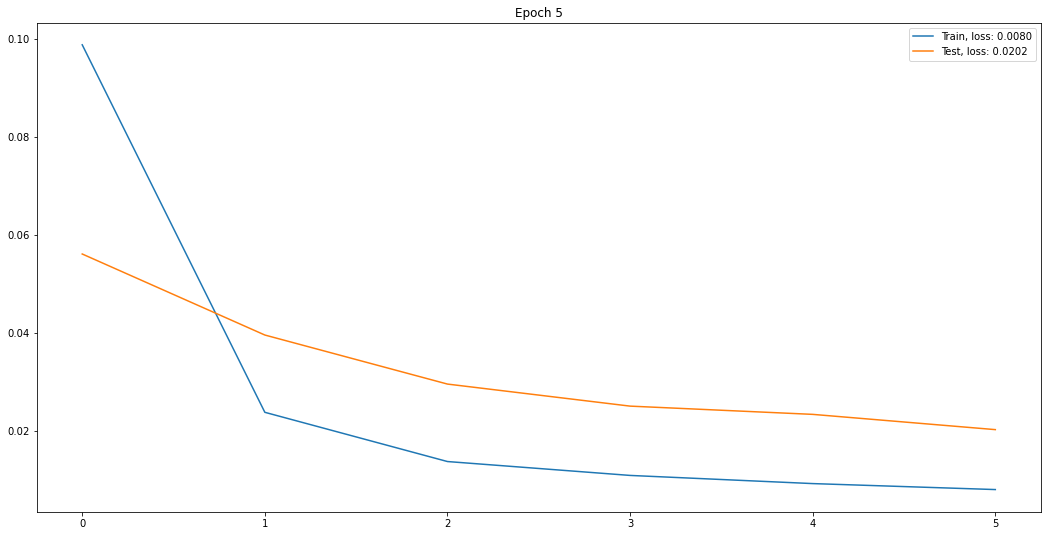

test losses: [tensor(0.0561, device='cuda:0'), tensor(0.0395, device='cuda:0'), tensor(0.0295, device='cuda:0'), tensor(0.0250, device='cuda:0'), tensor(0.0233, device='cuda:0'), tensor(0.0202, device='cuda:0')]


In [ ]:
train_losses = []
test_losses = []

best_loss = 0.05
num_epochs = 6
for i in range(num_epochs):
    
    train_loss = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss = test(model, criterion, testloader, i, device)
    scheduler.step(test_loss) 
    test_losses.append(test_loss)
      
    if test_loss < best_loss:
        print('Saving...')
        best_loss = test_loss
        model_info = {
            'model': model,
            'loss': best_loss
        }
        torch.save(model_info, 'X-radar_cropped/models/ckpt_transfer_learning.pth')
    
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

print('test losses:', test_losses)
    